<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, boundaries, advection, finite_differences, IBM_Force,convolution_functions,particle_motion
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct

In [3]:
jax.devices()

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

In [4]:
grid = jax_ib.base.grids.Grid(shape=(10, 10),domain = ((0,2*np.pi),(0,2*np.pi)))
array = jax_ib.base.grids.GridArray(np.zeros((10, 10)), offset=(0.5, 0.5), grid=grid)

In [5]:
#-- Initial velocity profile
def fun(x,y):
    return np.cos(x) * np.sin(y)

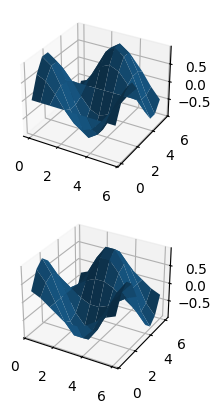

In [6]:
offsets = [(0,0), (0.5, 0.5)]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},ncols=1, nrows=len(offsets))
for n, o in enumerate(offsets):
    ev = grid.eval_on_mesh(fun, offset=o)
    mesh = grid.mesh(offset=o)
    ax[n].plot_surface(np.array(mesh[0]), np.array(mesh[1]), ev.data)

In [7]:
a = grid.eval_on_mesh(fun, offsets[0])
b = grid.eval_on_mesh(fun, offsets[1])
a + b # breaks due to inconsistent offsets

InconsistentOffsetError: arrays do not have a unique offset: {(0.5, 0.5), (0, 0)}

<font size="5"> Velocity fields live on the boundary surfaces between cells (offsets for vx and vy are  (1,0.5) and (0.5, 1)). Pressure lives at the cell center at offset = (0.5,0.5)<font size="5">v

In [537]:
#-- Flow conditions
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 

#-- CFD Boundary condition parameters
# parameters to parametrize time-dependent boundary conditions on walls of fluid domain
# ultimately we'd like to take e.g. a derivative over conditions
num_boundaries = 4 # in two dimensions there are 4 boundaries
freq=[0.]*4 #dummy paramters, oscillatory walls
#What are A,B,C,D? Why are the length-4 vectors? We don't need them here!?
#A=[0.]*4
#B=[0.]*4
#C=[0.]*4
#D=[0.]*4

domain = ((0,15.),(0,15.0))
size=(600,600)
grid = grids.Grid(size, domain=domain) #gridpoints in 

#def Boundary_fn(t): #can onlu depend on time at this point
#    return 0.0
# define boundary-condition functions which determine the fluid velocity at the boundaries
# of the domain; this is in 2D, so there are 4 boundaries. Boundaries can in principle
# be time dependent. There is one function per bounding surface and per velocity component, i.e.
# v_x_surface_1(t), v_y_surface_1(t), v_x_surface_2(t), ..., v_y_surface_4(t)
bc_fns = [lambda t: 0.0 for _ in range(num_boundaries)] #define boundary functions
vx_bc=((bc_fns[0](0.0), bc_fns[1](0.0)), (bc_fns[2](0.0),bc_fns[3](0.0)))
vy_bc=((0.0, 0.0), (0, 0.0))

# the values for bc_vals are actually violating the documented required values for periodic 
# boundary conditions; is this a problem????
# the docstring of the function boundaries.new_periodic_boundary_conditions seems to be outdated
# check with Mohammed if the description is still correct
velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)


#velocity_fns = (vx_fn, vy_fn)
# compute the initial values of the PDE variables (vx, vy in this case) over the grid
vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)
v0 = (vx_0, vy_0)
# Mohammed said they're using staggered mesh, pressure in the center, velolicites at the upper and left edge of the cell-square
# is this correct though? jax-cfd seems to be using arakawa c-grid with velocities at the face centers, and pressures on the edges?
#-- Initial Pressure Profile
# vx_0.bc.boundary_fn needs to be used here otherwise a 
# jax.lax.scan call will fail (need to investigate why this happens)
pressure0 = grids.GridVariable(
    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))

<font size="5"> Immersed Boudary Kinematics <font size="5">

In [538]:
#-- Immersed objects

# Immersed Objects Geometery and Initial locations
# object is described by center of the object
# theta is here a dummy variable; if f-term was used in addition to the f_b term, we'd need theat
def ellipse(geometry_param,theta):
    A = geometry_param[0]
    B = geometry_param[1]
    ntheta=150#30#400#51
    #xt = jnp.array(theta[:len(theta)//2]/(jnp.pi))
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


particle_geometry_param = jnp.array([[0.5,0.06]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects


# Immersed Objects kinematics
displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([[jnp.pi/2,jnp.pi/4,0.25,0]])


Displacement_EQ = ks.displacement # harmonic movement of the center in x-direction, coonstant in y-direction
Rotation_EQ = ks.rotation # constant rotation of the ellipse


mygrids = pc.Grid1d(2, domain= (0, 2*jnp.pi)) # Only needed when using Penalty method simulation setup

#wrap everythin into a single convenience object
particles =  pc.Particle(particle_center_position,
                         particle_geometry_param,
                         displacement_param,
                         rotation_param,mygrids,
                         ellipse,
                         Displacement_EQ,
                         Rotation_EQ)

In [539]:
inner_steps = 50#1800#20#450#1500#1300
outer_steps = 40#6000#12000#3000#2000#4500#4500#1800#10#900#20 (18000 works well to reach steady state)

#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0
MD_state = [0] # Needed when combinting Brownian integration with the Immersed Boundary simulation

all_variables = pc.All_Variables(particles,v0,pressure0,Intermediate_calcs,Step_counter,MD_state)


<font size="5"> Simulation Setup <font size="5">

In [540]:

#-- IB force coupling functions
def internal_post_processing(all_variables,dt):
    return all_variables

# Force convolution kernel
discrete_delta = lambda x,x0,w1: convolution_functions.gaussian(x,x0,w1)

# Convolution Discretized Integral
surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,discrete_delta)

# IB forcing function
#IBM_forcing = lambda variables,dt: IBM_Force.calc_IBM_force_NEW_MULTIPLE(variables,discrete_delta,surf_fn,dt)
IBM_forcing = lambda variables,dt: IBM_Force.immersed_boundary_force(variables[0], #velocity,
                                                                     variables[1], #particles 
                                                                     discrete_delta,
                                                                     surf_fn,
                                                                     dt)

#IBM_forcing = lambda variables,dt: IBM_Force.immersed_boundary_force(variables.velocity,
#                                                                     variables.particles,
#                                                                     discrete_delta,
#                                                                     surf_fn,
#                                                                     dt)
# Update particle position function
Update_position = particle_motion.Update_particle_position_Multiple

def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

single_step = ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag, #only works for periodic boundary conditions
        forcing=None, #pfo.arbitrary_obstacle(flow_cond.pressure_gradient,perm_f),
        time_stepper= ib.time_stepping.forward_euler_updated, #use runge-kutta , and keep it like that
        IBM_forcing = IBM_forcing, #comput ethe forcing term to update the particle
        Updating_Position = Update_position,
        Drag_fn = internal_post_processing, ### TO be removed from the example
        )
step_fn = cfd.funcutils.repeated(single_step, steps=inner_steps)

rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)
final_result, trajectory = jax.device_get(rollout_fn(all_variables))

In [541]:
@register_pytree_node_class
@dataclasses.dataclass
class MyClass:
    A: jax.Array
    b: jax.Array
    res: jax.Array
    def tree_flatten(self):
        return (self.A, self.b, self.res), None
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

In [325]:

def fun(c):
    c.res = jnp.matmul(c.A, c.b)
    c2 = MyClass(c.A, c.b, c.res)
    return c2

In [326]:
c = MyClass(jnp.ones((10,10)), jnp.ones(10), res = jnp.zeros(10))

In [327]:
jax.jit(fun)(c)

MyClass(A=Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32), b=Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), res=Array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32))

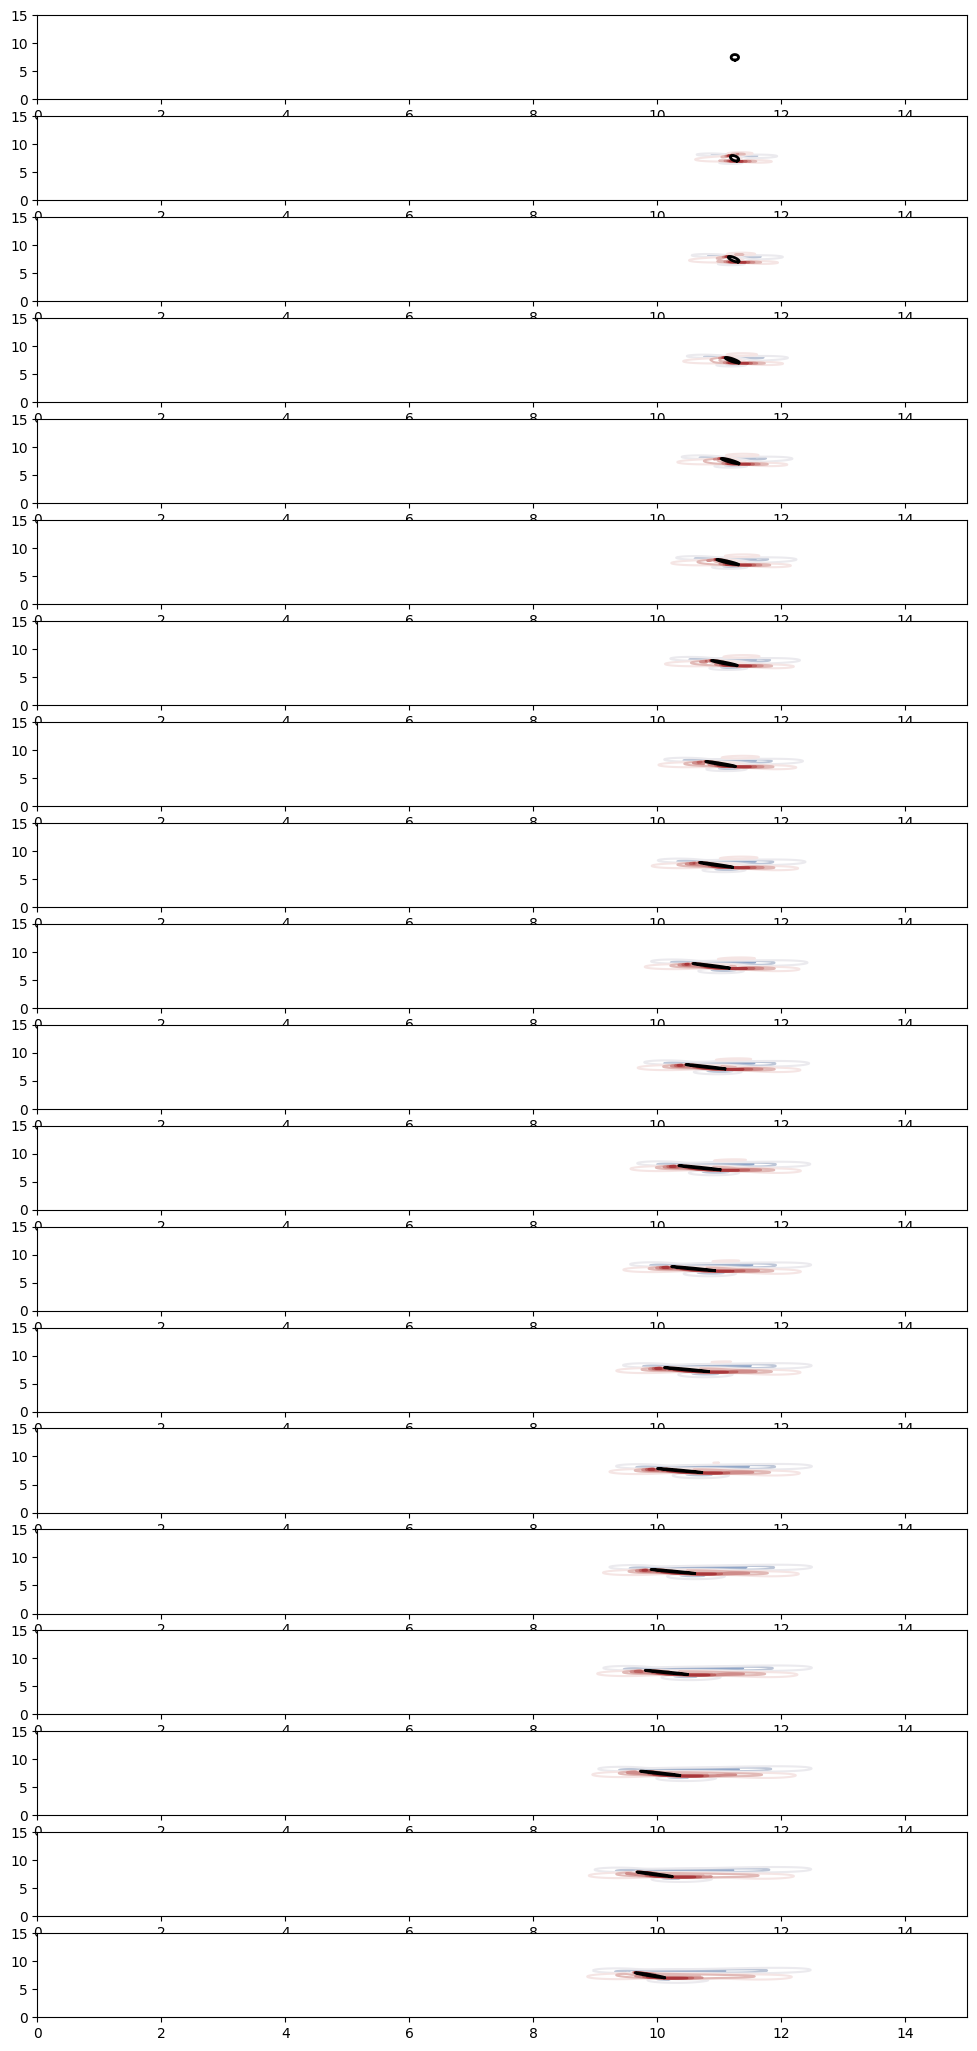

In [542]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from scipy.spatial.transform import Rotation
X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(trajectory,idx):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]),
           boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=trajectory.velocity[0].bc.time_stamp[idx]))


    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid), vel_bc[0]),
                     grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid), vel_bc[1]))

    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=outer_steps//2)


counter=0
for idx in range(0,outer_steps,2):

    ax[counter].contour(X,Y,calc_vorticity(trajectory,idx),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))

    particles_list = trajectory.particles
    geometry_param=particles_list.geometry_param[idx][0]
    xp0,yp0 = ellipse(geometry_param,0)

    current_t = trajectory.velocity[0].bc.time_stamp[idx]
    particle_center = particles_list.particle_center[idx][0]

    theta_t = Rotation_EQ(rotation_param,current_t)
    xp = (xp0)*jnp.cos(theta_t)-(yp0)*jnp.sin(theta_t)+particle_center[0]
    yp = (xp0)*jnp.sin(theta_t)+(yp0 )*jnp.cos(theta_t)+particle_center[1]
    ax[counter].set_xlim([0,15])
    ax[counter].set_ylim([0,15])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1


In [34]:
type(final_result.velocity[0].array.data)

numpy.ndarray